# TxMM Project - Pawpularity Contest
## Part II Google Cloud Vision API
Author: Lisa Hoek, contact at lisa.hoek@ru.nl

In [ ]:
!pip3 install -U pip google-cloud-vision

In [ ]:
import os
import re
import csv
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [ ]:
# Imports Credential File:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "INSERT_PRIVATE_KEY"
print("Service Account Key: {}".format(os.environ["GOOGLE_APPLICATION_CREDENTIALS"]))

In [ ]:
from __future__ import print_function
from google.cloud import vision
import io

def detect_labels(path):
  client = vision.ImageAnnotatorClient()

  with io.open(path, 'rb') as image_file:
    content = image_file.read()

  image = vision.Image(content=content)

  response = client.label_detection(image=image, max_results=50)
  labels = response.label_annotations
  
  print('Labels (and confidence score):')
  print('=' * 30)
  for label in labels:
    print(label.description, '(%.2f%%)' % (label.score*100.))

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train.csv')
print(train)

                                    Id  Subject Focus  ...  Blur  Pawpularity
0     0007de18844b0dbbb5e1f607da0606e0              0  ...     0           63
1     0009c66b9439883ba2750fb825e1d7db              0  ...     0           42
2     0013fd999caf9a3efe1352ca1b0d937e              0  ...     0           28
3     0018df346ac9c1d8413cfcc888ca8246              0  ...     0           15
4     001dc955e10590d3ca4673f034feeef2              0  ...     0           72
...                                ...            ...  ...   ...          ...
9907  ffbfa0383c34dc513c95560d6e1fdb57              0  ...     1           15
9908  ffcc8532d76436fc79e50eb2e5238e45              0  ...     0           70
9909  ffdf2e8673a1da6fb80342fa3b119a20              0  ...     0           20
9910  fff19e2ce11718548fa1c5d039a5192a              0  ...     0           20
9911  fff8e47c766799c9e12f3cb3d66ad228              0  ...     0           30

[9912 rows x 14 columns]


In [ ]:
img_loc = '/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/'+sample.Id.iloc[0]+'.jpg'
print(img_loc)

/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/00524dbf2637a80cbc80f70d3ff59616.jpg


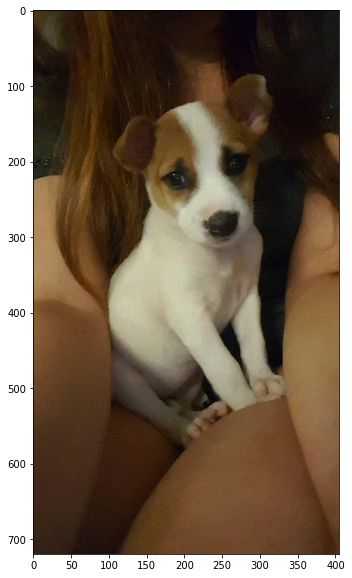

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(mpimg.imread(img_loc))
plt.show()

In [ ]:
detect_labels(img_loc)

Labels (and confidence score):
Dog (96.24%)
Carnivore (88.87%)
Dog breed (88.67%)
Fawn (81.56%)
Companion dog (81.51%)
Comfort (80.56%)
Working animal (80.10%)
Whiskers (79.99%)
Snout (75.66%)
Irishjacks (73.88%)
Sporting Group (68.31%)
Toy dog (66.24%)
Fur (64.61%)
Canidae (62.73%)
Terrestrial animal (56.05%)
Sitting (53.97%)
Paw (53.95%)
Non-Sporting Group (53.27%)
Human leg (52.88%)
Elbow (51.09%)


In [ ]:
simple = train[['Id', 'Pawpularity']]
simple.head()

,Id,Pawpularity
1,0009c66b9439883ba2750fb825e1d7db,42
7,0031d6a9ef7340f898c3e05f92c7bb04,35
13,006483b96ca9c09b7afed3e3d3af539d,41
16,006cda7fec46a527f9f627f4722a2304,34
23,0085bfb9a7ebfd776cb804d8b456bb05,50


In [ ]:
def getLabels(id):
  path = '/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/'+ id +'.jpg'
  client = vision.ImageAnnotatorClient()

  with io.open(path, 'rb') as image_file:
    content = image_file.read()

  image = vision.Image(content=content)

  response = client.label_detection(image=image, max_results=50)
  labels_res = response.label_annotations

  labels = []
  for label in labels_res:
    temp = (label.description, round(label.score*100,2))
    labels.append(temp)
  
  return labels

Create the dataset with labels

In [ ]:
from tqdm.notebook import tqdm

tqdm.pandas()

simple['Labels'] = simple['Id'].progress_apply(getLabels)
simpleEx = simple.explode('Labels')
simpleEx[['Feature', 'Score']] = pd.DataFrame(simpleEx['Labels'].tolist(), index=simpleEx.index)
simpleEx.drop(['Labels'], axis=1).to_csv('/content/drive/MyDrive/TxMM/data-34.csv')

  0%|          | 0/3703 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Reload the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TxMM/data.csv', index_col=0)
data.head()

,Id,Pawpularity,Feature,Score
0,0007de18844b0dbbb5e1f607da0606e0,63,Dog,94.73
0,0007de18844b0dbbb5e1f607da0606e0,63,Dog breed,88.66
0,0007de18844b0dbbb5e1f607da0606e0,63,Carnivore,84.56
0,0007de18844b0dbbb5e1f607da0606e0,63,Companion dog,79.11
0,0007de18844b0dbbb5e1f607da0606e0,63,Working animal,78.81


In [ ]:
from wordcloud import WordCloud, STOPWORDS
from operator import itemgetter
from collections import OrderedDict

def mk_wordfreq(i, j, df):
  mask = (df['Pawpularity'] >= i) & (df['Pawpularity'] <= j)
  df2 = df.loc[mask]
  wordfreqlist = list(zip(df2.Feature, df2.Score))
  wordfreq = {}
  for feature, score in wordfreqlist:
    sum = wordfreq.get(feature, 0) + score
    wordfreq[feature] = round(sum,2) 
  return wordfreq

def generate_wordcloud(wordfreq):
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  min_font_size = 5,
                  prefer_horizontal = 1).generate_from_frequencies(wordfreq)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

def generate_topN(i, j, df, n):
  wordfreq = mk_wordfreq(i, j, df)
  return dict(sorted(wordfreq.items(), key = itemgetter(1), reverse = True)[:n])

def filterBreeds(i, j, df, breeds):
  wordfreq = mk_wordfreq(i, j, df)
  #breedfreq = {k: wordfreq[k] if k in wordfreq else 0 for k in breeds}
  breedfreq = {k: wordfreq[k] for k in set(breeds) & set(wordfreq.keys())}
  #breedfreq = {k: wordfreq[k] for k in breeds}
  sorted_values = sorted(breedfreq.items(), key=itemgetter(1), reverse = True)
  return OrderedDict(sorted_values)

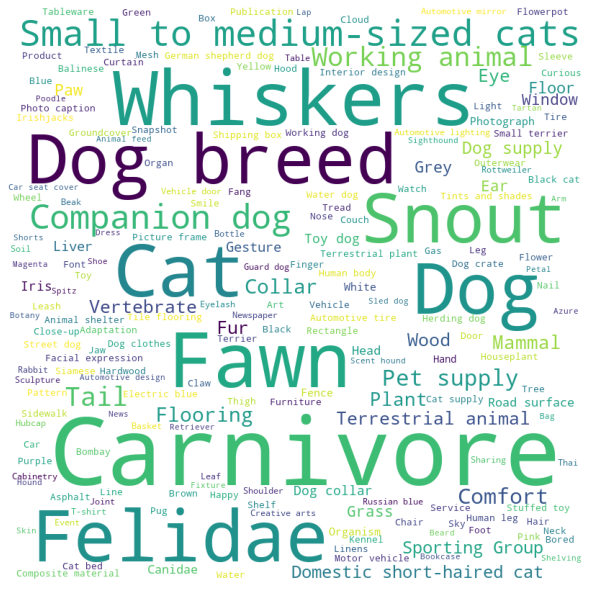

In [ ]:
generate_wordcloud(mk_wordfreq(41, 50, data))

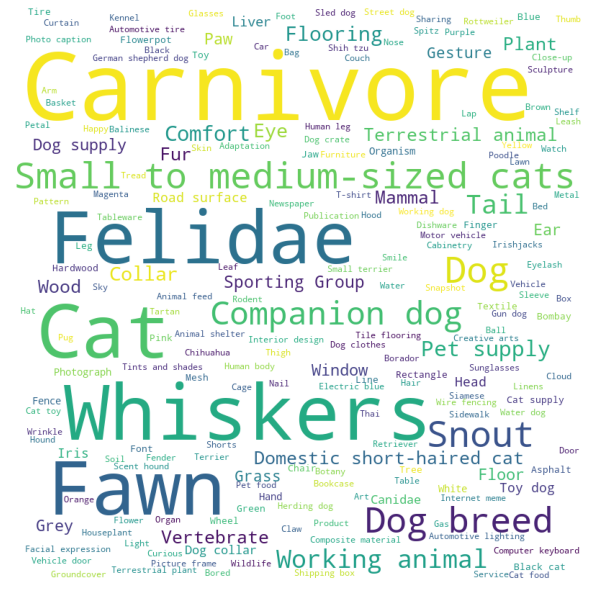

In [ ]:
generate_wordcloud(mk_wordfreq(1, 100, data))

In [ ]:
generate_topN(91, 100, data, 10)

{'Carnivore': 33561.51,
 'Cat': 9159.82,
 'Companion dog': 22465.93,
 'Dog': 26820.48,
 'Dog breed': 25305.63,
 'Fawn': 21207.56,
 'Felidae': 8633.48,
 'Snout': 17939.29,
 'Whiskers': 14807.18,
 'Working animal': 10662.45}

In [ ]:
generate_topN(1, 10, data, 10)

{'Carnivore': 34744.06,
 'Cat': 18170.29,
 'Companion dog': 16047.19,
 'Dog': 19318.63,
 'Dog breed': 18487.88,
 'Fawn': 20229.35,
 'Felidae': 17723.01,
 'Small to medium-sized cats': 16101.6,
 'Snout': 15955.2,
 'Whiskers': 19484.75}

In [ ]:
generate_topN(1, 100, data, 100)

{'Animal shelter': 7045.0,
 'Art': 7000.15,
 'Asphalt': 12171.16,
 'Automotive tire': 6879.95,
 'Black': 6284.17,
 'Black cat': 13238.19,
 'Blue': 12963.54,
 'Bombay': 13930.17,
 'Box': 6155.65,
 'Brown': 6275.2,
 'Canidae': 28227.65,
 'Car': 7150.8,
 'Carnivore': 850644.58,
 'Cat': 495399.69,
 'Cat supply': 10852.51,
 'Chair': 9476.45,
 'Close-up': 4031.91,
 'Collar': 108704.31,
 'Comfort': 130122.42,
 'Companion dog': 342523.84,
 'Couch': 8459.26,
 'Dog': 422943.94,
 'Dog breed': 404478.91,
 'Dog collar': 29412.8,
 'Dog crate': 5743.38,
 'Dog supply': 62201.69,
 'Domestic short-haired cat': 82556.83,
 'Door': 6814.98,
 'Ear': 57691.87,
 'Eye': 108498.52,
 'Fawn': 509318.79,
 'Felidae': 472900.6,
 'Fence': 19075.73,
 'Finger': 12772.52,
 'Floor': 65328.62,
 'Flooring': 117113.74,
 'Flowerpot': 10824.7,
 'Font': 14053.05,
 'Foot': 4763.44,
 'Fur': 93048.13,
 'Furniture': 5357.21,
 'Gas': 5359.66,
 'Gesture': 49361.24,
 'Grass': 47727.03,
 'Green': 11220.55,
 'Grey': 63753.1,
 'Groundco

Dog & Cat breeds

In [ ]:
cats = ['Balinese', 'Birman', 'Black cat', 'Bombay', 'British longhair',
 'Chihuahua', 'Domestic short-haired cat', 'Havana brown', 'Laperm', 'Maine coon',
 'Ragdoll', 'Russian blue', 'Siamese', 'Tonkinese']

In [ ]:
dogs = ['Australian cattle dog','Basenji','Beagle','Beaglier','Bernese mountain dog',
'Borador','Border collie','Border terrier','Boston terrier','Bull terrier','Bulldog',
'Chilean fox terrier','Chow chow','Companion dog','Dalmatian','Dobermann',
'Dogo sardesco','Finnish hound','German shepherd dog','German spitz','German spitz klein',
'German spitz mittel','Golden retriever','Great dane','Guard dog','Gun dog','Herding dog',
'Hound','Hunting dog','King charles spaniel','King shepherd','Labradoodle',
'Livestock guardian dog','Magyar agár','Maltepoo','Mcnab','Molosser','Moscow watchdog',
'Old german shepherd dog','Ori-pei','Pinscher', 'Pomeranian','Poodle','Pražský krysařík',
'Pudelpointer','Pug','Puggle','Puppy','Retriever','Rottweiler','Scent hound','Schnauzer',
'Shih tzu','Shih-poo','Siberian husky','Sighthound','Sled dog','Small terrier','Spaniel',
'Spitz','Standard Poodle','Standard schnauzer','Street dog','Terrier','Texas heeler',
'Toy dog','Water dog','Wire hair fox terrier','Working dog','Working terrier','Yorkipoo',
'Yorkshire terrier']

In [ ]:
filterBreeds(1, 100, data, cats)

OrderedDict([('Cat', 495399.69),
             ('Domestic short-haired cat', 82556.83),
             ('Bombay', 13930.17),
             ('Black cat', 13238.19),
             ('Siamese', 5083.66),
             ('Chihuahua', 2199.88),
             ('Balinese', 1164.95),
             ('Russian blue', 1055.94),
             ('Birman', 313.62),
             ('Ragdoll', 302.39),
             ('Laperm', 217.08),
             ('Maine coon', 143.42),
             ('British longhair', 139.22),
             ('Tonkinese', 130.93),
             ('Havana brown', 58.16)])

In [ ]:
filterBreeds(1, 100, data, dogs)

OrderedDict([('Dog', 422943.94),
             ('Companion dog', 342523.84),
             ('Terrier', 6691.63),
             ('Water dog', 4665.63),
             ('Street dog', 4338.71),
             ('German shepherd dog', 3357.0),
             ('Small terrier', 2993.01),
             ('Working dog', 2799.97),
             ('Herding dog', 2781.39),
             ('Poodle', 2383.83),
             ('Borador', 2047.2),
             ('Hound', 1954.66),
             ('Shih tzu', 1901.01),
             ('Rottweiler', 1809.54),
             ('Gun dog', 1560.92),
             ('Sled dog', 1516.19),
             ('Pug', 1337.9),
             ('Retriever', 1311.13),
             ('Scent hound', 1250.28),
             ('Spitz', 1128.88),
             ('Old german shepherd dog', 1027.67),
             ('Guard dog', 817.99),
             ('Dobermann', 674.99),
             ('Bulldog', 612.55),
             ('Boston terrier', 591.0),
             ('Shih-poo', 577.76),
             ('Beaglier', 575.27

In [ ]:
filterBreeds(91, 100, data, dogs)

OrderedDict([('Companion dog', 22465.93),
             ('Terrier', 1211.49),
             ('Water dog', 1202.26),
             ('Poodle', 845.86),
             ('Small terrier', 783.68),
             ('Sled dog', 747.48),
             ('Shih tzu', 636.0),
             ('Spitz', 579.12),
             ('German shepherd dog', 547.05),
             ('Retriever', 424.05),
             ('German spitz', 368.06),
             ('Shih-poo', 367.12),
             ('Old german shepherd dog', 310.4),
             ('Gun dog', 285.05),
             ('Rottweiler', 276.27),
             ('German spitz mittel', 222.87),
             ('Siberian husky', 221.7),
             ('Hound', 192.18),
             ('Standard schnauzer', 157.44),
             ('Boston terrier', 147.71),
             ('Beaglier', 124.95),
             ('Maltepoo', 124.11),
             ('Street dog', 121.13),
             ('Pug', 97.21),
             ('Bulldog', 91.22),
             ('Schnauzer', 78.44),
             ('German spitz 

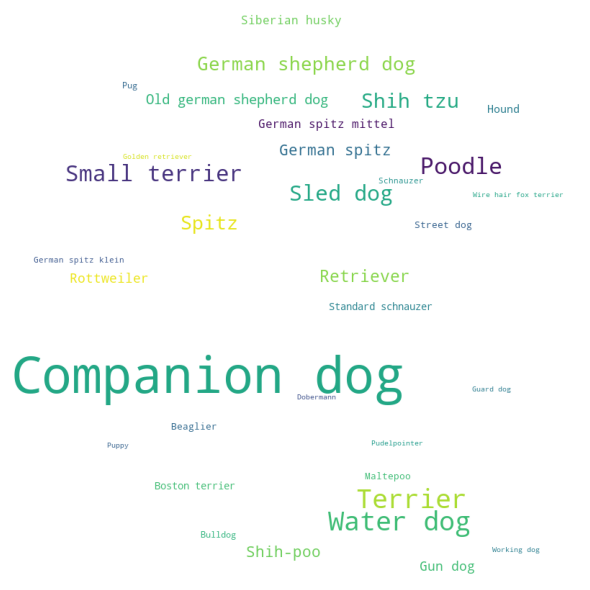

In [ ]:
generate_wordcloud(filterBreeds(91, 100, data, dogs))

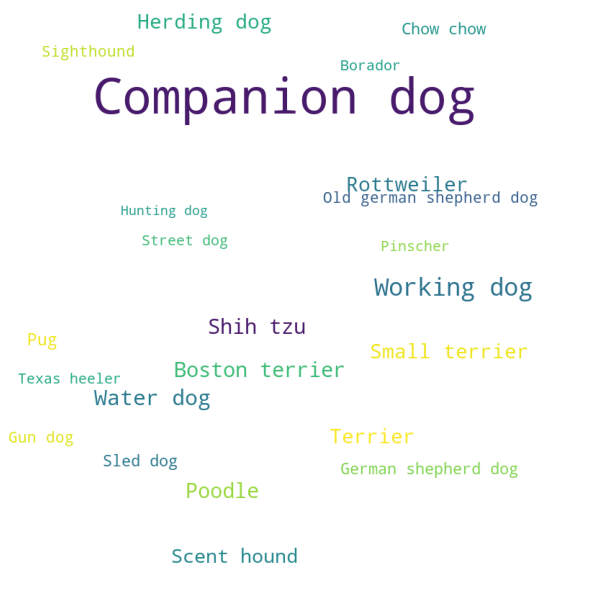

In [ ]:
generate_wordcloud(filterBreeds(1, 10, data, dogs))

In [ ]:
def get_info(i, j):
  mask = (data['Pawpularity'] >= i) & (data['Pawpularity'] <= j)
  df = data.loc[mask]
  print(df.nunique())
  print('Length:', len(df.index))

In [ ]:
get_info(91, 100)

Id              388
Pawpularity      10
Feature         228
Score          2096
dtype: int64
Length: 3880
